In [226]:
from astroML.time_series import generate_damped_RW 

Parameter [lower bound, upper bound]
log(M/M⊙) [6.5, 9.5]
log(L/Ledd) [-2, 0]
z [0.1, 2.5]
amplitude (mag) [0.0, 1.0]
period (days) [360, 1080]
sawtoothiness (%) [0.0, 1.0 ]
phase [0.0, 2π]


In [228]:
def generateFixedSample():
    amplitude = 0.5
    tau = 1000
    t_rest = list(range(1,3650)) # days for 10 yrs
    redshift = 1
    period = 3*365
    drw = generate_damped_RW(t_rest, tau, redshift)
    sine = [ amplitude * math.sin(2 * math.pi * (x % period) / period) for x in t_rest ]
    drw_sine = [ (drw[x] + sine[x]) for x in range (len (t_rest))]  
    return (t_rest, drw_sine, drw, sine)

In [229]:
import random
def generateRandomSample(survey_params):
    # amplitude of sinusoidal signal
    amplitude = random.uniform(0.05, 0.5) 
    print("sinusoidal signal amplitude=" + str(amplitude))

    # tau parameter for damped random walk
    tau = random.uniform(survey_params.observation_period/1000, 15*survey_params.observation_period)
    print("DRW tau=" + str(tau))

    # redshift between 0.1 to 2.5
    redshift = random.uniform(0.1, 2.5)
    print("redshift=" + str(redshift))

    # period of binary between 30 days to 10 yrs
    period = random.uniform(30, survey_params.observation_period)
    print("sinusoidal signal period=" + str(period))

    # Observations have certain cadence. e.g. expected to be every ~7 days for LSST. Therefore,
    t_rest = list(range(1, survey_params.observation_period, survey_params.cadence))
    # 7 days cadence is not exact, so add Gaussian noise with sigma = 1 day (for LSST) to the observation days
    t_rest = [ x + random.gauss(0, survey_params.cadence_deviation) for x in t_rest ]

    # Generate the damped random walk signal
    drw = generate_damped_RW(t_rest, tau, redshift)

    # Generate sinusoidal signal for binary
    sine = [ amplitude * math.sin(2 * math.pi * (x % period) / period) for x in t_rest ]

    # Sum the DRW and sinusoidal signals
    drw_sine = [ (drw[x] + sine[x]) for x in range (len (t_rest))]  

    # Add gaussian noise to simulate photometric error
    drw_sine = [ x + random.gauss(0, survey_params.photometric_error) for x in drw_sine ]

    # wipe off about 6 months signal every year due to simulate gaps in observation
    drw_sine_with_gaps = []
    t_rest_with_gaps = []
    gap_start = random.uniform(1,  365 - survey_params.gap_period)
    gap_end = gap_start + survey_params.gap_period
    for x in range(0, len(t_rest)):
        if ((t_rest[x] % 365) < gap_start or (t_rest[x] % 365) >= gap_end):
            drw_sine_with_gaps.append(drw_sine[x])
            t_rest_with_gaps.append(t_rest[x])
    print("total num observations=" + str(len(t_rest_with_gaps)))
        
    return (t_rest_with_gaps, drw_sine_with_gaps, t_rest, drw, sine)

In [230]:
from dataclasses import dataclass
@dataclass(frozen=True)
class SurveyParams:
    observation_period: float
    cadence: float
    cadence_deviation: float
    photometric_error: float
    gap_period: float

# Parameters for different surveys, to be confirmed
LSST = SurveyParams(observation_period = 10 * 365, cadence = 7, cadence_deviation = 1, photometric_error = 0.01, gap_period = 182)
CRTS = SurveyParams(observation_period = 7 * 365, cadence = 20, cadence_deviation = 3, photometric_error = 0.1, gap_period = 182)
IMLT = SurveyParams(observation_period = 7 * 365, cadence = 7, cadence_deviation = 3, photometric_error = 0.1, gap_period = 182) 
AXIS = SurveyParams(observation_period = 7 * 365, cadence = 7, cadence_deviation = 3, photometric_error = 0.1, gap_period = 182)

sinusoidal signal amplitude=0.42171406960384283
DRW tau=31489.952529349757
redshift=0.24436047381270037
sinusoidal signal period=564.7151557308019
total num observations=63


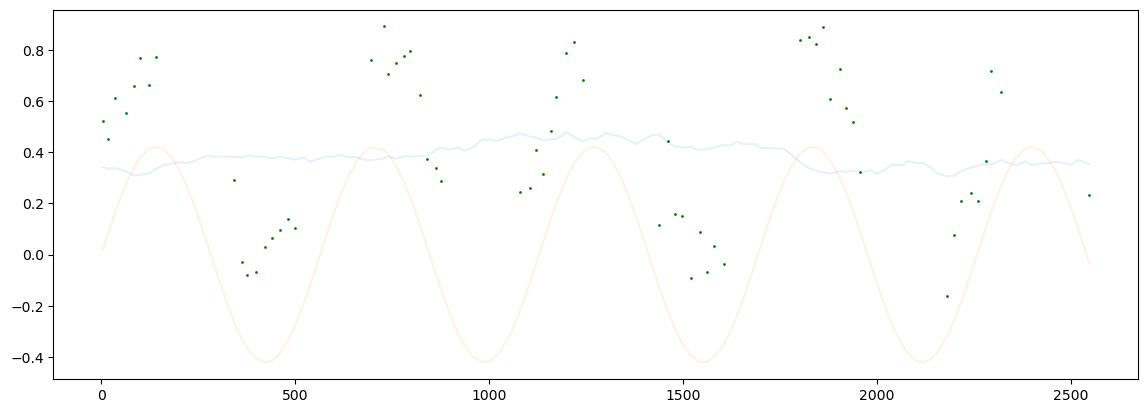

In [231]:
#main
#print(generateFixedSample())
import matplotlib.pyplot as plt
import math

light_curve = generateRandomSample(CRTS) #  generateFixedSample / generateRandomSample(LSST) 
plt.figure().set_figwidth(14)
plt.scatter(light_curve[0], light_curve[1], 1, c='green')
plt.plot(light_curve[2], light_curve[3], alpha=0.1)
plt.plot(light_curve[2], light_curve[4], alpha=0.1)
#plt.figure(figsize=(18,6))

plt.show()